In [213]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from fm import *
from scipy import interp

#loading in data again just to be safe
wlgrid, y_meas, err=np.loadtxt('chimera_toi199-2.dat').T

#setting up default parameter values--SET THESE TO SAME VALUES AS IN LOG-LIKE FUNCTION
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp= 0.865#0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.829#0.598   #Stellar Radius in Solar Radii
M = 0.271#1.78    #Mass in Jupiter Masses

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=400. #1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
logKir=-2  #TP profile IR opacity controlls the "vertical" location of the gradient
logg1=-2  #-1     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
Tint=300.

#Composition parameters---assumes "chemically consistnat model" described in Kreidberg et al. 2015
logMet=1.0  # x[1]#1.5742E-2 #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1 used -1.01*log10(M)+0.6
logCtoO=-0.26  #x[2]#-1.97  #log C-to-O ratio: log solar is -0.26
logPQCarbon= 1.50185314  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value
logPQNitrogen= 1.90333421  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  --ad hoc for chemical kinetics--reasonable assumption
#A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
fsed=2.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
logCldVMR=-2.5 #cloud fraction
#simple 'grey+rayleigh' parameters--non scattering--just pure extinction
logKcld = -38 
logRayAmp = -30 
RaySlope = 0 
xRp=0.899

In [7]:
xsecs=xsects_JWST(1666,20000)

Cross-sections Loaded


TP profile:

1e-06 341.01


(2.5, -6)

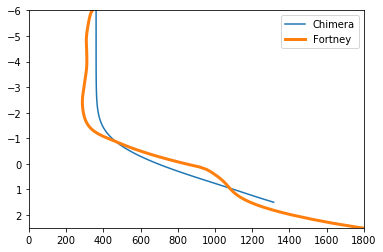

In [214]:
logP = np.arange(-6.8,1.5,0.1)+0.1
P = 10.0**logP
g0=6.67384E-11*M*1.898E27/(Rp*xRp*71492.*1.E3)**2
kv=10.**(logg1+logKir)
kth=10.**logKir
tp=TP(Tirr, Tint,g0 , kv, kv, kth, 0.5)
Tarr = interp(logP,np.log10(tp[1]),tp[0])
plt.plot(Tarr,logP,label='Chimera')
plt.gca().invert_yaxis()
p,t = np.loadtxt('tp_fortney.pt',unpack=True,usecols=(1,2))
print(p[0],t[0])
plt.plot(t,np.log10(p),label='Fortney',lw=3)
plt.legend()
plt.xlim(0,1800)
plt.ylim(2.5,-6)

In [215]:
#g0=6.67384E-11*M*1.898E27/(Rp*xRp*71492.*1.E3)**2
#kv=10.**(logg1+logKir)
#kth=10.**logKir
#tp=TP(Tirr, Tint,g0 , kv, kv, kth, 0.5)
x=np.array([Tirr, logKir,logg1, Tint,logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.])
y_binned,y_mod,wno,atm=fx_trans(x,wlgrid,gas_scale, xsecs)

(0.94, 0.999)

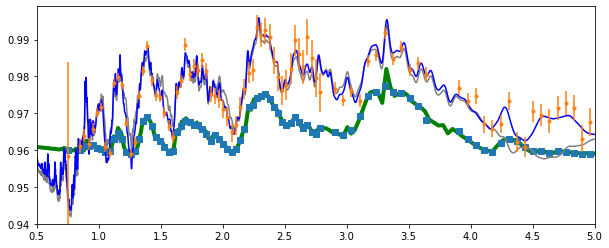

In [188]:
plt.figure(figsize=(10,4))
plt.plot(1E4/wno, y_mod*100,'g',lw=4,zorder=1)
plt.plot(wlgrid, y_binned*100,'s',lw=4,zorder=1)
plt.errorbar(wlgrid, y_meas*100, err*100,fmt='.')
cent_lambda, ed = np.loadtxt('no-quench.dat',unpack=True)
plt.plot(cent_lambda, ed, label='No-quenching model', color='grey',zorder=1)

cent_lambda, ed = np.loadtxt('quench.dat',unpack=True)
plt.plot(cent_lambda, ed, label='Quenched (input model)', color='blue',zorder=1)
plt.xlim(0.5,5.)
plt.ylim(0.94,0.999)

Generate data using this model:

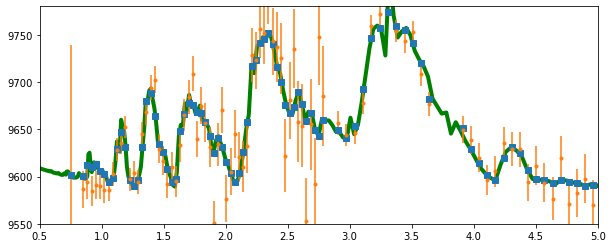

In [230]:
plt.figure(figsize=(10,4))
n_nirspec = 2
sim_data = np.zeros(len(wlgrid))
idx = np.where(wlgrid>2.8)[0]
new_err = np.copy(err)
new_err[idx] = new_err[idx]/np.sqrt(n_nirspec)
for i in range(len(wlgrid)):
    sim_data[i] = np.random.normal(y_binned[i],new_err[i],1)[0]
plt.plot(wlgrid,y_binned*1e6,'s')
plt.plot(1E4/wno, y_mod*1e6,'g',lw=4,zorder=1)
plt.errorbar(wlgrid,sim_data*1e6,new_err*1e6,fmt='.')
plt.xlim(0.5,5.)
plt.ylim(9550,9780)
fout = open('chimera_toi199-3-sc.dat','w')
for i in range(len(wlgrid)):
    fout.write('{0:.3f} {1:.10f} {2:.10f}\n'.format(wlgrid[i],sim_data[i],new_err[i]))
fout.close()

Check how no quenching looks like:

In [204]:
fout = open('chimera_toi199-3-sc.dat-realQUENCHmodel.dat','w')
for i in range(len(wno)):
    fout.write('{0:.10f} {1:.10f}\n'.format(1E4/wno[i],y_mod[i]))
fout.close()

In [209]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from fm import *
from scipy import interp

#loading in data again just to be safe
wlgrid, y_meas, err=np.loadtxt('chimera_toi199-2.dat').T

#setting up default parameter values--SET THESE TO SAME VALUES AS IN LOG-LIKE FUNCTION
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp= 0.865#0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.829#0.598   #Stellar Radius in Solar Radii
M = 0.271#1.78    #Mass in Jupiter Masses

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=400. #1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
logKir=-2  #TP profile IR opacity controlls the "vertical" location of the gradient
logg1=-2#-1     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
Tint=300.

#Composition parameters---assumes "chemically consistnat model" described in Kreidberg et al. 2015
logMet=1.0#x[1]#1.5742E-2 #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1 used -1.01*log10(M)+0.6
logCtoO=-0.26#x[2]#-1.97  #log C-to-O ratio: log solar is -0.26
logPQCarbon= -3#1.50185314  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value
logPQNitrogen= -3#1.90333421  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  --ad hoc for chemical kinetics--reasonable assumption
#A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
fsed=2.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
logCldVMR=-2.5 #cloud fraction
#simple 'grey+rayleigh' parameters--non scattering--just pure extinction
logKcld = -38 
logRayAmp = -30 
RaySlope = 0 
xRp=0.899

#g0=6.67384E-11*M*1.898E27/(Rp*xRp*71492.*1.E3)**2
#kv=10.**(logg1+logKir)
#kth=10.**logKir
#tp=TP(Tirr, Tint,g0 , kv, kv, kth, 0.5)
x=np.array([Tirr, logKir,logg1, Tint,logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.])
y_binned,y_mod,wno,atm=fx_trans(x,wlgrid,gas_scale, xsecs)

(9550, 9780)

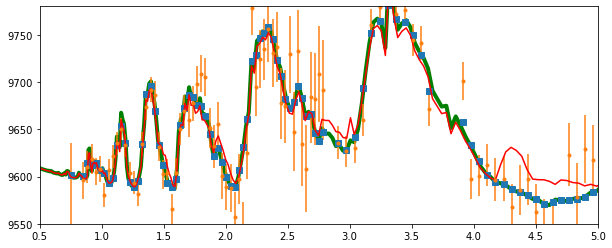

In [210]:
plt.figure(figsize=(10,4))
sim_data = np.zeros(len(wlgrid))
for i in range(len(wlgrid)):
    sim_data[i] = np.random.normal(y_binned[i],err[i],1)[0]
plt.plot(wlgrid,y_binned*1e6,'s')
plt.plot(1E4/wno, y_mod*1e6,'g',lw=4,zorder=1)
plt.errorbar(wlgrid,sim_data*1e6,err*1e6,fmt='.')
ww,mm = np.loadtxt('chimera_toi199-2-sc.dat-realQUENCHmodel.dat',unpack=True)
plt.plot(ww,mm*1e6,color='red')
plt.xlim(0.5,5.)
plt.ylim(9550,9780)